In [1]:
!pip install earthpy

You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


In [53]:
#import required libraries 
%matplotlib inline
import os 
import numpy as np 
import geopandas as gpd 
import pandas as pd
import rasterio 
from rasterio.enums import Resampling
from rasterio.plot import show 
import matplotlib.pyplot as plt
import shutil
import xarray as xr
from odc.algo import xr_reproject
from datacube.utils.cog import write_cog
from datacube.utils.geometry import assign_crs
from datacube.testutils.io import rio_slurp_xarray
from odc.algo import xr_reproject
import earthpy.plot as ep
import seaborn as sn
from glob import glob 
import gdal
sn.set()
sn.set_theme(color_codes=True)

In [5]:
# Read sampling points from shapefile
#pts = gpd.read_file('..//Real_world_examples/LCCSlayer/coherence/samples_250m_landuse.shp')
pts = gpd.read_file('..//Real_world_examples/LCCSlayer/coherence/samples_250m_landuse_QLUMP_2019.shp')

In [6]:
pts.columns

Index(['Join_Count', 'TARGET_FID', 'Id', 'gridcode', 'Value', 'Land_Cover',
       'Red', 'Green', 'Blue', 'XGeometry', 'YGeometry', 'QLD_LC', 'Year',
       'QLUMP_Code', 'ALUM_Code', 'Primary', 'Secondary', 'Tertiary', 'RuleID',
       'geometry'],
      dtype='object')

In [7]:
pts = pts[['XGeometry', 'YGeometry', 'Value', 'Land_Cover','Primary','Secondary','Tertiary','geometry']]

In [8]:
pts.index = range(len(pts))

In [9]:
pts[:20]

,XGeometry,YGeometry,Value,Land_Cover,Primary,Secondary,Tertiary,geometry
0,151.838928,-24.915437,17,Natural Terrestrial Vegetated: Woody Closed (>...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83893 -24.91544)
1,151.819501,-24.920239,24,Natural Terrestrial Vegetated: Herbaceous Open...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.81950 -24.92024)
2,151.824447,-24.919550,24,Natural Terrestrial Vegetated: Herbaceous Open...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82445 -24.91955)
3,151.829422,-24.919021,18,Natural Terrestrial Vegetated: Woody Open (40 ...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82942 -24.91902)
4,151.838485,-24.917380,23,Natural Terrestrial Vegetated: Herbaceous Open...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83848 -24.91738)
5,151.847092,-24.915276,18,Natural Terrestrial Vegetated: Woody Open (40 ...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.84709 -24.91528)
6,151.838465,-24.920018,18,Natural Terrestrial Vegetated: Woody Open (40 ...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83847 -24.92002)
7,151.820244,-24.924771,10,Cultivated Terrestrial Vegetated: Herbaceous O...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82024 -24.92477)
8,151.748954,-24.936994,23,Natural Terrestrial Vegetated: Herbaceous Open...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.74895 -24.93699)
9,151.778580,-24.932831,18,Natural Terrestrial Vegetated: Woody Open (40 ...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.77858 -24.93283)


In [10]:
#Rename the columns in the LCCS table 
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Open (15 to 40 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Open (40 to 65 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Scattered (1 to 4 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Sparse (4 to 15 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Closed (> 65 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)

pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Closed (> 65 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Open (15 to 40 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Open (40 to 65 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Scattered (1 to 4 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Sparse (4 to 15 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)

pts["Land_Cover"].replace({"Water: (Water) Non-perennial (1 to 3 months)":"Water Non-perennial"}, inplace=True)
pts["Land_Cover"].replace({"Water: (Water) Perennial (> 9 months)":"Water Perennial"}, inplace=True)
pts["Land_Cover"].replace({"Water: (Water) Tidal area":"Water Tidal"}, inplace=True)
pts["Land_Cover"].replace({"Water: (Water) Non-perennial (4 to 6 months)":"Water Non-perennial"}, inplace=True)
pts["Land_Cover"].replace({"Water: (Water) Non-perennial (7 to 9 months)":"Water Non-perennial"}, inplace=True)

pts["Land_Cover"].replace({"Natural Surface: Very sparsely vegetated":"Natural Surface"}, inplace=True)
pts["Land_Cover"].replace({"Natural Surface: Sparsely vegetated":"Natural Surface"}, inplace=True)
pts["Land_Cover"].replace({"Natural Surface: Bare areas, unvegetated":"Natural Surface"}, inplace=True)

pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Sparse (4 to 15 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Scattered (1 to 4 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Open (40 to 65 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Open (15 to 40 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Closed (> 65 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)

pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Sparse (4 to 15 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Scattered (1 to 4 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Open (40 to 65 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Open (15 to 40 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Closed (> 65 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)

In [11]:
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated(Woody)":"Natural Vegetation"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated(Herbaceous)":"Natural Vegetation"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated(Herbaceous)":"Cultivated Vegetation"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated(Woody)":"Cultivated Vegetation"}, inplace=True)
pts["Land_Cover"].replace({"Water Non-perennial":"Water","Water Perennial":"Water"}, inplace=True)

In [12]:
pts

,XGeometry,YGeometry,Value,Land_Cover,Primary,Secondary,Tertiary,geometry
0,151.838928,-24.915437,17,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83893 -24.91544)
1,151.819501,-24.920239,24,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.81950 -24.92024)
2,151.824447,-24.919550,24,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82445 -24.91955)
3,151.829422,-24.919021,18,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82942 -24.91902)
4,151.838485,-24.917380,23,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83848 -24.91738)
...,...,...,...,...,...,...,...,...
114363,150.390731,-28.799205,18,Natural Vegetation,None,None,None,POINT (150.39073 -28.79920)
114364,150.396980,-28.795945,25,Natural Vegetation,None,None,None,POINT (150.39698 -28.79594)
114365,150.401951,-28.793741,24,Natural Vegetation,None,None,None,POINT (150.40195 -28.79374)
114366,150.406337,-28.792577,11,Cultivated Vegetation,None,None,None,POINT (150.40634 -28.79258)


In [13]:
coords = [(x,y) for x, y in zip(pts.XGeometry, pts.YGeometry)]

In [14]:
# Open the coherence mean raster file and store metadata
coh_median = rasterio.open('..//Real_world_examples/LCCSlayer/coherence/coh_median.tif')

In [15]:
coh_mean = rasterio.open('..//Real_world_examples/LCCSlayer/coherence/coh_mean.tif')

In [16]:
# Sample the mean layer at every point location and store values in DataFrame
pts['Median of Coherence'] = [x for x in coh_median.sample(coords)]
pts['Median of Coherence'] = pts.apply(lambda x: x['Median of Coherence'][0], axis=1)

In [17]:
# Open the coherence SD raster file and store metadata
coh_std = rasterio.open('..//Real_world_examples/LCCSlayer/coherence/coh_std.tif')

In [18]:
# Sample the std layer at every point location and store values in DataFrame
pts['Standard Deviation of Coherence'] = [x for x in coh_std.sample(coords)]
pts['Standard Deviation of Coherence'] = pts.apply(lambda x: x['Standard Deviation of Coherence'][0], axis=1)

In [19]:
pts['Mean of Coherence'] = [x for x in coh_mean.sample(coords)]
pts['Mean of Coherence'] = pts.apply(lambda x: x['Mean of Coherence'][0], axis=1)

In [20]:
pts

,XGeometry,YGeometry,Value,Land_Cover,Primary,Secondary,Tertiary,geometry,Median of Coherence,Standard Deviation of Coherence,Mean of Coherence
0,151.838928,-24.915437,17,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83893 -24.91544),0.187238,0.113947,0.183304
1,151.819501,-24.920239,24,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.81950 -24.92024),0.240032,0.181511,0.259874
2,151.824447,-24.919550,24,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82445 -24.91955),0.221618,0.159756,0.231249
3,151.829422,-24.919021,18,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82942 -24.91902),0.166817,0.094377,0.158654
4,151.838485,-24.917380,23,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83848 -24.91738),0.187238,0.113947,0.183304
...,...,...,...,...,...,...,...,...,...,...,...
114363,150.390731,-28.799205,18,Natural Vegetation,None,None,None,POINT (150.39073 -28.79920),0.160945,0.079544,0.165711
114364,150.396980,-28.795945,25,Natural Vegetation,None,None,None,POINT (150.39698 -28.79594),0.310512,0.189569,0.345608
114365,150.401951,-28.793741,24,Natural Vegetation,None,None,None,POINT (150.40195 -28.79374),0.436490,0.152244,0.431321
114366,150.406337,-28.792577,11,Cultivated Vegetation,None,None,None,POINT (150.40634 -28.79258),0.418491,0.181307,0.420946


In [21]:
#Get the geometry of the points 
from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame
geometry = [Point(xy) for xy in zip(pts.XGeometry, pts.YGeometry)]
crs = {'init': 'epsg:4326'} 
samplepoints = GeoDataFrame(pts, crs=crs, geometry=geometry)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [22]:
AOI = '..//Real_world_examples/LCCSlayer/coherence/AOI_Assessment.shp'

In [23]:
outline = gpd.read_file(AOI).to_crs('EPSG:4326')
outline

,Id,geometry
0,0,"POLYGON ((150.09506 -25.87995, 152.05659 -25.8..."


In [70]:
Zone_points = gpd.clip(samplepoints, outline)

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


In [71]:
Zone_points.count()

XGeometry                          59266
YGeometry                          59266
Value                              59266
Land_Cover                         59266
Primary                            59266
Secondary                          59266
Tertiary                           59266
geometry                           59266
Median of Coherence                59266
Standard Deviation of Coherence    59266
Mean of Coherence                  59266
dtype: int64

In [72]:
#pts_random_50pc = pts.sample(frac=0.5, replace=True, random_state=1)
#pts_selected = pts[5000:10000]
#pts_selected = pts_selected.rename(columns={'Coh_mean':'Mean of Coherence','Coh_SD':'Standad Deviation of Coherence'})

In [73]:
Zone_points.groupby('Land_Cover').size()

Land_Cover
Artificial Surface         144
Cultivated Vegetation    13801
Natural Surface           3610
Natural Vegetation       41144
Water                      567
dtype: int64

In [74]:
NatVeg = Zone_points[Zone_points["Land_Cover"] == 'Natural Vegetation']
CultVeg = Zone_points[Zone_points["Land_Cover"] == 'Cultivated Vegetation']
Water =  Zone_points[Zone_points["Land_Cover"] == 'Water']
NatSurf = Zone_points[Zone_points["Land_Cover"] == 'Natural Surface']
ArtSurf = Zone_points[Zone_points["Land_Cover"] == 'Artificial Surface']

In [75]:
palette ={"Natural Vegetation": "green", "Cultivated Vegetation": "orange", "Water": "blue", "Natural Surface": "red","Artificial Surface":"cyan"}

Text(0.3, 0.02, 'No.samples:144')

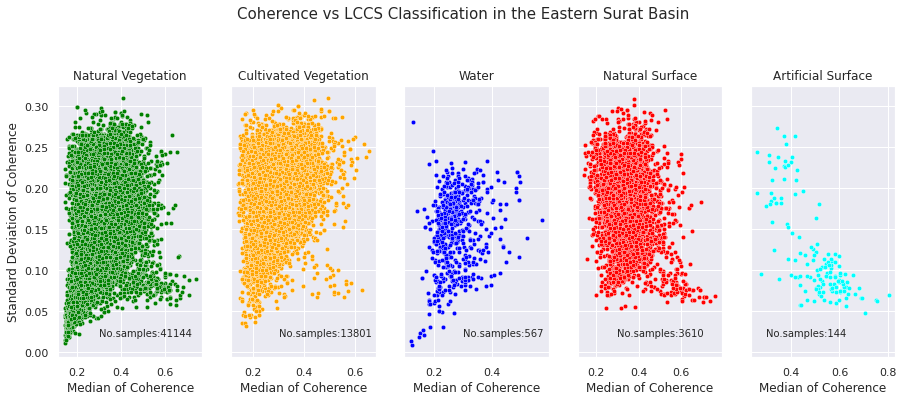

In [76]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
fig.suptitle('Coherence vs LCCS Classification in the Eastern Surat Basin',fontsize=15, y=1.1)

sn.scatterplot(ax =axes[0],x="Median of Coherence", y="Standard Deviation of Coherence", color ="green", data=NatVeg,s=20)
axes[0].set_title("Natural Vegetation")
axes[0].text(0.3, 0.02, 'No.samples:41144', fontsize=10)
sn.scatterplot(ax =axes[1],x="Median of Coherence", y="Standard Deviation of Coherence", color ="orange", data=CultVeg,s=20)
axes[1].set_title("Cultivated Vegetation")
axes[1].text(0.3, 0.02, 'No.samples:13801', fontsize=10)
sn.scatterplot(ax =axes[2],x="Median of Coherence", y="Standard Deviation of Coherence", color ="blue",data=Water,s=20)
axes[2].set_title("Water")
axes[2].text(0.3, 0.02, 'No.samples:567', fontsize=10)
sn.scatterplot(ax =axes[3],x="Median of Coherence", y="Standard Deviation of Coherence", color="red", data=NatSurf,s=20)
axes[3].set_title("Natural Surface")
axes[3].text(0.3, 0.02, 'No.samples:3610', fontsize=10)
sn.scatterplot(ax =axes[4],x="Median of Coherence", y="Standard Deviation of Coherence", color="cyan", data=ArtSurf,s=20)
axes[4].set_title("Artificial Surface")
axes[4].text(0.3, 0.02, 'No.samples:144', fontsize=10)

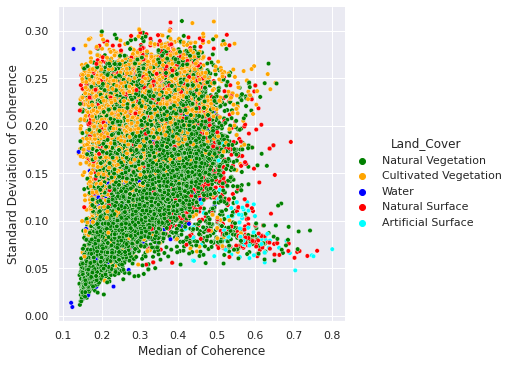

In [77]:
sn.relplot(x="Median of Coherence", y="Standard Deviation of Coherence", hue="Land_Cover",sizes=(4, 4), data=Zone_points,s=20, palette=palette);

In [131]:
Zone_points["Tertiary"].replace({"Aquaculture":"Water","Marsh/wetland":"Water","Marsh/wetland - conservation":"Water","Marsh/wetland - production":"Water","Water extraction and transmission":"Water","Water storage - intensive use/farm dams":"Water","Sewage":"Water","River":"Water","Lake - conservation":"Water","Lake":"Water","Effluent pond":"Water"}, inplace=True)
Zone_points["Tertiary"].replace({"Irrigated cereals":"Irrigated land","Irrigated citrus":"Irrigated land","Irrigated cotton":"Irrigated land","Irrigated cropping":"Irrigated land","Irrigated grapes":"Irrigated land","Irrigated hay and silage":"Irrigated land","Irrigated oilseeds":"Irrigated land","Irrigated olives":"Irrigated land","Irrigated perennial horticulture":"Irrigated land","Irrigated seasonal fruits":"Irrigated land","Irrigated seasonal horticulture":"Irrigated land","Irrigated seasonal vegetables and herbs":"Irrigated land",
                                "Irrigated shrub berries and fruits":"Irrigated land","Irrigated sugar":"Irrigated land","Irrigated tree fruits":"Irrigated land","Irrigated turf farming":"Irrigated land","Irrigated vine fruits":"Irrigated land","Irrigated woody fodder plants":"Irrigated land","Degraded irrigated land":"Irrigated land"}, inplace=True)
Zone_points["Tertiary"].replace({"Land in transition":"Other","Abandoned manufacturing and industrial":"Other","Abandoned land":"Other","Abandoned perennial horticulture":"Other","Extractive industry not in use":"Other"}, inplace=True)
Zone_points["Tertiary"].replace({"Rural":"Residential","Remote communities":"Residential","Urban residential":"Residential","Rural residential without agriculture":"Residential","Rural residential with agriculture":"Residential","Rural residential with agriculture":"Residential","Rural residential without agriculture":"Residential"}, inplace=True)
Zone_points["Tertiary"].replace({"Recreation and culture":"Infrastructure","Reservoir/dam":"Infrastructure","Saleyards/stockyards":"Infrastructure","Horse studs":"Infrastructure","Poultry farms":"Infrastructure","Services":"Infrastructure","Manufacturing and industrial":"Infrastructure","Public services":"Infrastructure","Research facilities":"Infrastructure","Residential and farm infrastructure":"Infrastructure","Navigation and communication":"Infrastructure","Abattoirs":"Infrastructure","Rehabilitation":"Infrastructure","Roads":"Infrastructure","Transport and communication":"Infrastructure","Airports/aerodromes":"Infrastructure","Bulk grain storage":"Infrastructure","Channel/aqueduct":"Infrastructure", "Commercial services":"Infrastructure","Dairy sheds and yards":"Infrastructure","Defence":"Infrastructure","Defence facilities - urban":"Infrastructure","Electricity substations and transmission":"Infrastructure","Farm buildings/infrastructure":"Infrastructure","Feedlots":"Infrastructure","Food processing factory":"Infrastructure","Fuel powered electricity generation":"Infrastructure",
                                "Gas treatment, storage and transmission":"Infrastructure","Shadehouses":"Infrastructure","Sawmill":"Infrastructure","Railways":"Infrastructure"}, inplace=True)
Zone_points["Tertiary"].replace({"Hay and silage":"Crops","Perennial horticulture":"Crops","Cereals":"Crops","Cotton":"Crops","Cropping":"Crops","Intensive horticulture":"Crops","Vine fruits":"Crops","Intensive horticulture":"Crops","Tree nuts":"Crops","Tree fruits":"Crops","Shrub berries and fruits":"Crops","Olives":"Crops","Oilseeds":"Crops"},inplace=True)
Zone_points["Tertiary"].replace({"Managed resource protection":"Other","Evaporation basin":"Other","Habitat/species management area":"Other","Other conserved area":"Other","Other minimal use":"Other"}, inplace=True)
Zone_points["Tertiary"].replace({"Plantation forests":"Forestry","Hardwood plantation forestry":"Forestry","Woody fodder plants":"Forestry","Softwood plantation forestry":"Forestry","Production native forests":"Forestry"}, inplace=True)
Zone_points["Tertiary"].replace({"Tailings":"Mining","Quarries":"Mining","Mines":"Mining","Reservoir":"Mining"},inplace=True)
Zone_points["Tertiary"].replace({"Landfill":"Other","Waste treatment and disposal":"Other","Solid garbage":"Other"},inplace=True)
Zone_points["Tertiary"].replace({"National park":"Natural Vegetation","Residual native cover":"Natural Vegetation","Natural feature protection":"Natural Vegetation","Grazing irrigated modified pastures":"Natural Vegetation","Grazing modified pastures":"Natural Vegetation","Grazing native vegetation":"Natural Vegetation","Intensive animal production":"Natural Vegetation","Piggeries":"Natural Vegetation"},inplace=True)


In [135]:
palette2 ={"Natural Vegetation": "green","Crops":"orange","Forestry":"lime", "Mining": "black","Water": "blue", "Irrigated land":"yellowgreen","Abondoned Land":"Gray","Residential":"gold","Infrastructure":"darkslategray","Other":"cyan"}


In [136]:
sn.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

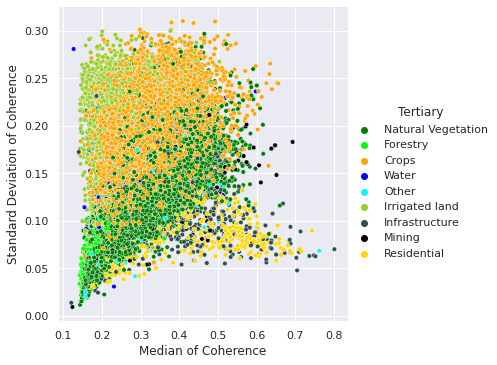

In [137]:
sn.relplot(x="Median of Coherence", y="Standard Deviation of Coherence", hue="Tertiary",sizes=(4, 4), data=Zone_points,s=20,palette=palette2);

In [138]:
NaturalVeg = Zone_points[Zone_points["Tertiary"] == 'Natural Vegetation']
Forest = Zone_points[Zone_points["Tertiary"] == 'Forestry']
Crops =  Zone_points[Zone_points["Tertiary"] == 'Crops']
Water = Zone_points[Zone_points["Tertiary"] == 'Water']
Other = Zone_points[Zone_points["Tertiary"] == 'Other']
Irrigatedland = Zone_points[Zone_points["Tertiary"] == 'Irrigated land']
Infrastructure = Zone_points[Zone_points["Tertiary"] == 'Infrastructure']
Mining = Zone_points[Zone_points["Tertiary"] == 'Mining']
Residential = Zone_points[Zone_points["Tertiary"] == 'Residential']

In [139]:
Zone_points.groupby('Tertiary').size()

Tertiary
Crops                 22443
Forestry               2387
Infrastructure          973
Irrigated land         5152
Mining                  340
Natural Vegetation    25945
Other                   334
Residential            1020
Water                   672
dtype: int64

Text(0.3, 0.02, 'No.samples:334')

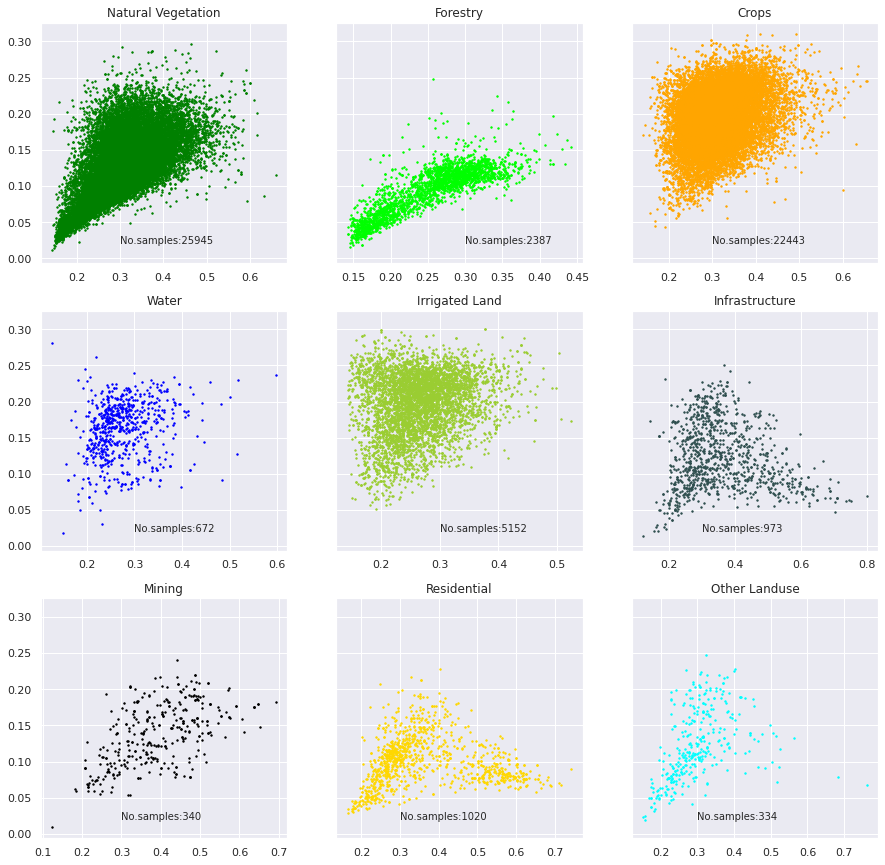

In [140]:
f, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(15, 15),sharex=False, sharey = True)
axes[0, 0].scatter(x="Median of Coherence", y="Standard Deviation of Coherence", color ="green", data=NaturalVeg,s=2)
axes[0, 0].set_title("Natural Vegetation")
axes[0, 0].text(0.3, 0.02, 'No.samples:25945', fontsize=10)
axes[0, 1].scatter(x="Median of Coherence", y="Standard Deviation of Coherence", color ="lime", data=Forest,s=2)
axes[0, 1].set_title("Forestry")
axes[0, 1].text(0.3, 0.02, 'No.samples:2387', fontsize=10)
axes[0, 2].scatter(x="Median of Coherence", y="Standard Deviation of Coherence", color ="orange", data=Crops,s=2)
axes[0, 2].set_title("Crops")
axes[0, 2].text(0.3, 0.02, 'No.samples:22443', fontsize=10)
axes[1, 0].scatter(x="Median of Coherence", y="Standard Deviation of Coherence", color ="blue", data=Water,s=2)
axes[1, 0].set_title("Water")
axes[1, 0].text(0.3, 0.02, 'No.samples:672', fontsize=10)
axes[1, 1].scatter(x="Median of Coherence", y="Standard Deviation of Coherence", color ="yellowgreen", data=Irrigatedland,s=2)
axes[1, 1].set_title("Irrigated Land")
axes[1, 1].text(0.3, 0.02, 'No.samples:5152', fontsize=10)
axes[1, 2].scatter(x="Median of Coherence", y="Standard Deviation of Coherence", color ="darkslategray", data=Infrastructure,s=2)
axes[1, 2].set_title("Infrastructure")
axes[1, 2].text(0.3, 0.02, 'No.samples:973', fontsize=10)
axes[2, 0].scatter(x="Median of Coherence", y="Standard Deviation of Coherence", color ="black", data=Mining,s=2)
axes[2, 0].set_title("Mining")
axes[2, 0].text(0.3, 0.02, 'No.samples:340', fontsize=10)
axes[2, 1].scatter(x="Median of Coherence", y="Standard Deviation of Coherence", color ="gold", data=Residential,s=2)
axes[2, 1].set_title("Residential")
axes[2, 1].text(0.3, 0.02, 'No.samples:1020', fontsize=10)
axes[2, 2].scatter(x="Median of Coherence", y="Standard Deviation of Coherence", color ="cyan", data=Other,s=2)
axes[2, 2].set_title("Other Landuse")
axes[2, 2].text(0.3, 0.02, 'No.samples:334', fontsize=10)

In [129]:
Zone_points.columns

Index(['XGeometry', 'YGeometry', 'Value', 'Land_Cover', 'Primary', 'Secondary',
       'Tertiary', 'geometry', 'Median of Coherence',
       'Standard Deviation of Coherence', 'Mean of Coherence'],
      dtype='object')

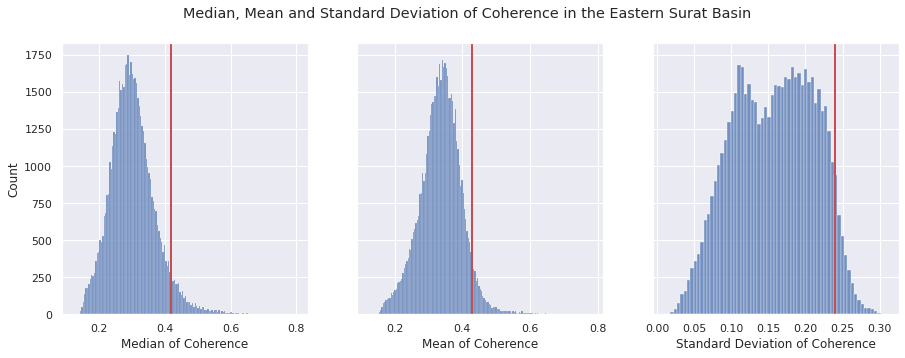

In [121]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Median, Mean and Standard Deviation of Coherence in the Eastern Surat Basin')
sn.histplot(ax =axes[0],x=Zone_points["Median of Coherence"])
axes[0].axvline(x=.42,linewidth=2, color='r')
sn.histplot(ax =axes[1],x=Zone_points["Mean of Coherence"])
axes[1].axvline(x=.43,linewidth=2, color='r')
sn.histplot(ax =axes[2],x=Zone_points["Standard Deviation of Coherence"])
axes[2].axvline(x=.24,linewidth=2, color='r')

In [122]:
NewPts=Zone_points.rename(columns={"Median of Coherence": "Median", "Standard Deviation of Coherence": "STD","Mean of Coherence":"Mean"})

In [118]:
NewPts[['Median','STD','Mean']].dropna().quantile([0.0, .5, .90, .95])

,Median,STD,Mean
0.00,0.120853,0.009050,0.122567
0.50,0.297112,0.160183,0.338450
0.90,0.389495,0.228973,0.408695
0.95,0.424483,0.240914,0.431721
